# Transform
Transform prealigned images and send it Dodam for quality check of CNN

### Reading and Writing Data

In [232]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import h5py
import numpy as np
import src.visual as vis
from scipy.misc import imresize
path = '/FilterFinder/data/Dodam/'
path_s = '/FilterFinder/data/prealigned/'
from PIL import Image

In [233]:
def read(name, (x,y), size):
    with h5py.File(path_s+name+'.h5', 'r') as hf:
        data = hf.get('img')
        sample = np.array(data[x:x+size, y:y+size])
    return imresize(sample, (512, 512))/255.0

def get_shape(name):
    hf = h5py.File(path_s+name+'.h5', 'r')
    return hf.get('img').shape

def create_dataset(name, shape=(30159, 40229)):
    hf = h5py.File(path+name+'.h5')
    dset = hf.create_dataset("img", shape, dtype='uint8')
    return dset

def write(array, (x, y), dset):
    dset[x:x+array.shape[0], y:y+array.shape[1]] += array

def normalize(image):
    image += abs(image.min())
    image /= abs(image.max())
    image *= 255.0
    return image
    
def save(image, name='out'):
    im = image+np.abs(image.min())
    im = 255*(im/im.max())
    im = np.squeeze(im)
    #print(im.shape)
    result = Image.fromarray(im.astype(np.uint8))
    result.save(name+'.jpg')

0.25
[[ 0.00097656  0.00195312  0.00292969 ...,  0.00292969  0.00195312
   0.00097656]
 [ 0.00195312  0.00292969  0.00390625 ...,  0.00390625  0.00292969
   0.00195312]
 [ 0.00292969  0.00390625  0.00488281 ...,  0.00488281  0.00390625
   0.00292969]
 ..., 
 [ 0.00292969  0.00390625  0.00488281 ...,  0.00488281  0.00390625
   0.00292969]
 [ 0.00195312  0.00292969  0.00390625 ...,  0.00390625  0.00292969
   0.00195312]
 [ 0.00097656  0.00195312  0.00292969 ...,  0.00292969  0.00195312
   0.00097656]]


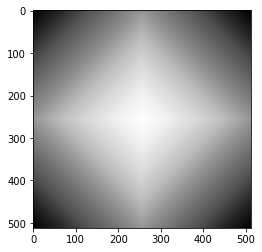

In [234]:
def f(x, y, pad, length):
    if (x>=pad and y>=pad) and (x<length-pad and y<length-pad):
        return 1

    #corners
    scale_down = 4*float(pad)
    if (x<pad and y<pad):
        return (x+y+1)/(scale_down)
    
    if (x>length-pad-1 and y>length-pad-1):
        return (2*length-x-y-1)/(scale_down)  #(length-x-1)/(2*float(pad)**2)
    
    if (x<pad and y>length-pad-1):
        return (length+x-y)/(scale_down) #y/(2*float(pad)**2)
    
    if (x>length-pad-1 and y<pad):
        return (length-x+y)/(scale_down)
    
        
    #edges
    if (x<pad) and (y>=pad and y<=length-pad-1):
        return (x+0.5)/float(pad)
    
    if (y<pad) and (x>=pad and x<=length-pad-1):
        return (y+0.5)/float(pad)
    
    if (x>pad) and (y>=pad and y<=length-pad-1):
        return (length-x-0.5)/float(pad)
    
    if (y>pad) and (x>=pad and x<=length-pad-1):
        return (length-y-0.5)/float(pad)
    
    return 0
def get_blend_map(pad, size):
    blend_map = np.zeros((size, size))
    for x in range(size):
        for y in range(size):
            blend_map[x,y] = f(x,y, pad, size)
    return blend_map

blend_map = get_blend_map(256,512)
print(blend_map.mean())
print(blend_map)
vis.show(np.abs(blend_map*100))

In [235]:
pathset = [ (120,9900, 11000), (20, 9900, 11000),
            (60, 16000, 17000),(70, 16000, 17000),
            (400, 8500, 27000),(400, 7000, 27000),
            (300, 7000, 21500),(151, 4500, 5000),
            (51, 18000, 9500), (52, 18000, 7500),
            (55, 18000, 7500), (60, 18100, 8400)]

### Loading The model

In [236]:
import tensorflow as tf
import src.model as models
import src.data as d
import src.metrics as metrics
import src.training as training
import src.loss as loss
import src.visual as vis
import hyperparams
import numpy as np
import src.helpers as helpers

In [237]:
hparams = hyperparams.create_hparams()
data = d.Data(hparams)
model = models.create_model(hparams, data,train = False)

[[3, 3, 1, 8], [3, 3, 8, 16], [3, 3, 16, 32]]
Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
FusionNet
encode


ValueError: Variable Passes/layer_0_0 already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/FilterFinder/src/helpers.py", line 25, in weight_variable
    initializer=tf.contrib.layers.xavier_initializer())
  File "/FilterFinder/src/helpers.py", line 38, in add_conv_weight_layer
    kernels.append(weight_variable(kernel_shape, identity_init, name='layer_'+stringID, summary=False))
  File "/FilterFinder/src/helpers.py", line 116, in conv_block
    kernels, bias = add_conv_weight_layer(kernels, bias, kernel_shape)


In [ ]:
t, s = data.getBatch(hparams, pathset)

model_run =[model.source_alpha]

feed_dict ={model.image: np.array([read("1,80_prealigned", (10000,10000),3*512) for i in range(8)]), 
            model.template: t, 
            model.dropout: 1}

In [11]:
args = model.sess.run(model_run,feed_dict=feed_dict)



ValueError: Cannot feed value of shape (8, 512, 512) for Tensor u'input/Placeholder:0', which has shape '(12, 512, 512)'

In [10]:
images = args[0][-1][-1][:,:,0]
images -= images.min()
images = images/images.max()
src = read("1,80_prealigned", (10000,10000),3*512)
vis.show(np.multiply(images<0.5, 1)+0.9*src)
blend = get_blend_map(256,512)

print(images)
images = normalize(images)

print(images)

images = imresize(images,(512,512))
images= np.multiply(images, blend)
images = images.astype(np.int32)
images = images[0:256, 0:256]+images[256:512, 256:512]+images[0:256, 256:512]+images[256:512, 0:256 ]
print(images.max())
vis.show(images)
vis.show(read("1,80_prealigned", (10000,10000),3*512))
#save(read("12,1_prealigned", (10000,10000),3*224))

NameError: name 'args' is not defined

### Transforming slices

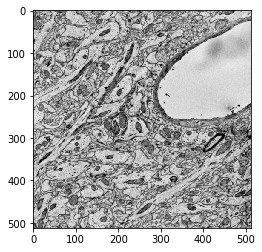

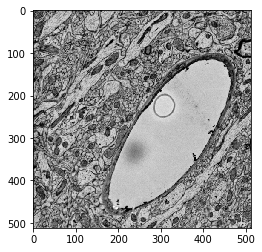

In [10]:
vis.show(read("1,80_prealigned", (10000,10000),512*3))
vis.show(s[0])

In [10]:
# Process by batches
def process(name, (x,y), dset, blend_map, scale=3):
    model_run =[model.source_alpha]
    
    feed_dict ={model.image: np.array([read(name, (x+i*scale*256,y),scale*512) for i in range(8)]), 
                model.template: t, 
                model.dropout: 1}
    args = model.sess.run(model_run,feed_dict=feed_dict)
    
    for i in range(8):
        image = args[0][-1][i][:,:,0]
        image = normalize(image)
        #image = 255*np.ones((512,512))
        image = imresize(image,(scale*512,scale*512))
        image = np.multiply(image, blend_map)
        image = image.astype(np.uint8)
        #image = image + read(name+"_transformed", (x+i*scale*256, y), scale*512)
        #print()
        #print(image.size)
        #vis.show(image)
        write(image, (x+i*scale*256, y), dset) 
    return image 


### Run on whole dataset

In [11]:
def process_dataset(name):
    blend_map = get_blend_map(3*256,3*512)
    #print(blend_map)
    shape = get_shape(name) #(30159, 40229)
    dset = create_dataset(name[0:2]+'20'+name[2:], shape=shape)
    step_x = 8*3*256
    step_y = 3*256
    #process(name, (0,39), dset, blend_map)
    for x in range(shape[0]//(step_x)):
        for y in range(shape[1]//(step_y)-2):
            #print((x,y))
            process(name, (x*step_x,y*step_y), dset, blend_map)

In [15]:
#process_dataset("1,4_prealigned")
#process_dataset("1,81_prealigned")

In [16]:
done = [(1,2), (1,3)]
def process_all():
    for i in range(1):
        for x in range(28,97):
            if (i+2,x+2) in done:
                print('pass',i+1,x+2)
                continue
            try:
                process_dataset(str(i+1)+','+str(x+2)+'_'+'prealigned')
                done.extend((i+1, x+2))
                print(i+1,x+2)
            except:
                print('err',i+1,x+2)

In [ ]:
process_all()

(1, 30)
(1, 31)
('err', 1, 32)
(1, 33)
(1, 34)
(1, 35)
(1, 36)
(1, 37)
(1, 38)
('err', 1, 39)
('err', 1, 40)
(1, 41)


In [ ]:
a = get_blend_map(8,16)
print(a.mean())
b = a[0:8,0:8]+a[8:16, 8:16] + a[0:8,8:16]+a[8:16, 0:8]
print(b.mean())
vis.show(a[0:8,0:8]+a[8:16, 8:16] + a[0:8,8:16]+a[8:16, 0:8])

In [11]:
a = "1,80_prealigned"

In [ ]:
print('3', 1,2)

In [25]:
process_dataset(str(1)+','+str(24)+'_'+'prealigned')

ValueError: operands could not be broadcast together with shapes (1107,1536) (1536,1536) (1107,1536) 

In [ ]:
process_dataset(str(1)+','+str(29)+'_'+'prealigned')

## Pathological Cases

In [238]:
pathset = [ (120,9900, 11000), (20, 9900, 11000),
            (60, 16000, 17000),(70, 16000, 17000),
            (400, 8500, 27000),(400, 7000, 27000),
            (300, 7000, 21500),(151, 4500, 5000),
            (51, 18000, 9500), (52, 18000, 7500),
            (55, 18000, 7500), (60, 18100, 8400),]

In [370]:
t, s = data.getBatch(hparams, pathset)

feed_dict = {model.image: s, 
                model.template: t, 
                model.dropout: 1}

model_run =[model.source_alpha,
            model.template_alpha,
            model.p,
           ]



In [240]:
args = model.sess.run(model_run,feed_dict=feed_dict)
sess = tf.InteractiveSession()
n = 12
search = tf.placeholder(tf.float32, shape=[n, 512, 512])
template = tf.placeholder(tf.float32, shape=[n, 160, 160])
out = helpers.normxcorr2FFT(search, template)

result = sess.run(out, feed_dict={template: t, search: s})

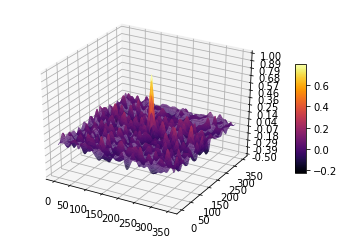

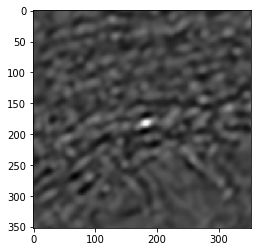

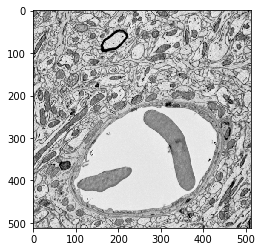

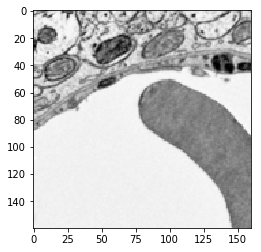

In [376]:

step = 4# 7, 1, 4
#vis.show(s[step])

s_pro = args[0][-1][step][:,:,0]
t_pro = args[1][-1][step][:,:,0]
n_pro = args[2][step]
#images -= images.min()
#images = images/images.max()
#src = s[0]
#src = read("1,80_prealigned", (10000,10000),3*512)
#vis.show(np.multiply(images<0.5, 1)+0.9*src)
#blend = get_blend_map(256,512)
#images = normalize(images)

#images = imresize(images,(512,512))
#images= np.multiply(images, blend)
#mages = images.astype(np.int32)
#images = images[0:256, 0:256]+images[256:512, 256:512]+images[0:256, 256:512]+images[256:512, 0:256 ]
#vis.show(s[step])


xcsurface(n_pro)
vis.show(n_pro)
vis.show(s[step])
vis.show(t[step])


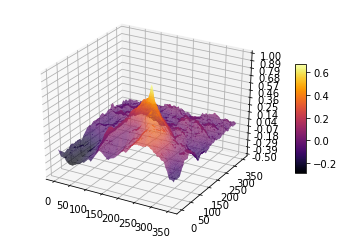

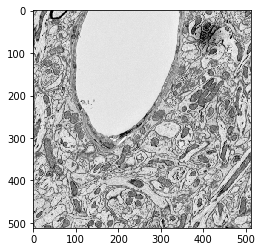

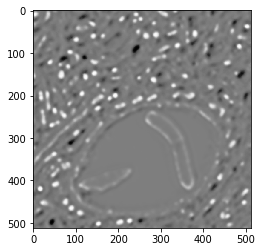

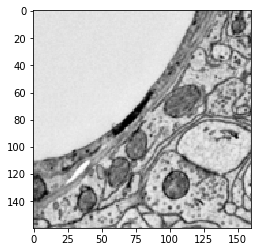

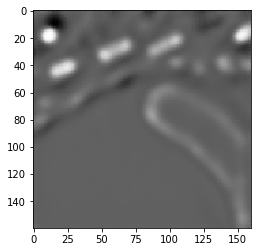

In [382]:
step = 5
xcsurface(result[step])
#vis.show(result[step])
vis.show(s[step])
vis.show(normalize(s_pro))
vis.show(t[step])
vis.show(normalize(t_pro))


In [352]:
from scipy.misc import imresize
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
def xcsurface(xc):


    N=xc.shape[0]
    M=xc.shape[1]
    X = np.arange(0, N, 1)
    Y = np.arange(0, M, 1)
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure("xc") #,figsize=(10,10))
    plt.clf()

    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, xc, rstride=2, edgecolors="k",
                    cstride=2, cmap=cm.inferno, alpha=1, linewidth=0,
                    antialiased=True)
    ax.set_zlim(-0.5, 1)

    ax.zaxis.set_major_locator(LinearLocator(15))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=10)

In [353]:
step = 6 # 7, 1, 4
vis.show(s[step])
vis.show(t[step])
#xcsurface(result[step])
#vis.show(result[step])

TypeError: 'int' object has no attribute '__getitem__'

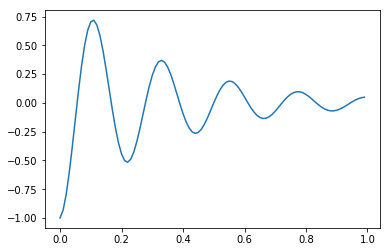

In [136]:
def f(t):
    return -np.exp(-3*t) * np.cos(9*np.pi*t)

t1 = np.arange(0.0, 1.0, 0.01)

plt.figure(1)
plt.plot(t1, f(t1))

plt.show()

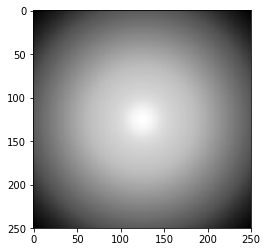

In [351]:
def f(x, y, s):
    return (1/(np.pi*s))*np.exp(-(x**2+y**2)/s,)

step = 4
a = np.ones((250,250))
sigma = 0.005
for x in range(a.shape[0]):
    for y in range(a.shape[1]):
        a[x,y] = f((x+0.0001)/250-0.5, (y+0.0001)/250-0.5, sigma)
        
sigma = 0.5
for x in range(a.shape[0]):
    for y in range(a.shape[1]):
        a[x,y] += 500*f((x+0.0001)/250-0.5, (y+0.0001)/250-0.5, sigma)

sigma = 4
for x in range(a.shape[0]):
    for y in range(a.shape[1]):
        a[x,y] += f((x+0.0001)/250+1, (y+0.0001)/250+1, sigma)

    
vis.show(a)
#xcsurface(a)


In [256]:
np.pi

3.141592653589793